In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns

# Load production data
production_df = pd.read_csv('production.csv')

# Load weather data
weather_df = pd.read_csv("processed_weather.csv")

# Convert 'date' column to datetime and 'hour' column to numeric in weather dataframe
weather_df['datetime'] = pd.to_datetime(weather_df['date'] + ' ' + weather_df['hour'].astype(str) + ':00:00')

# Drop unnecessary columns from the weather dataframe
weather_df.drop(['date', 'hour'], axis=1, inplace=True)

# Reshape the weather data to wide format
weather_wide = weather_df.pivot_table(index='datetime', 
                                      columns=['lat', 'lon'], 
                                      values=['dswrf_surface', 'tcdc_low.cloud.layer', 'tcdc_middle.cloud.layer',
                                              'tcdc_high.cloud.layer', 'tcdc_entire.atmosphere', 'uswrf_top_of_atmosphere',
                                              'csnow_surface', 'dlwrf_surface', 'uswrf_surface', 'tmp_surface'],
                                      aggfunc='first')

# Flatten the multi-level column index
weather_wide.columns = ['_'.join(map(str, col)).strip() for col in weather_wide.columns.values]

# Reset the index to make 'datetime' a column again
weather_wide.reset_index(inplace=True)

# Convert 'date' column to datetime and 'hour' column to numeric in production dataframe
production_df['datetime'] = pd.to_datetime(production_df['date'] + ' ' + production_df['hour'].astype(str) + ':00:00')

# Drop unnecessary columns from the production dataframe
production_df.drop(['date', 'hour'], axis=1, inplace=True)

# Merge the reshaped weather data with the production data on the 'datetime' column
merged_data = pd.merge(weather_wide, production_df, on='datetime', how='inner')
merged_data.sort_values(by=['datetime'], inplace=True)


available_data = merged_data[~merged_data['production'].isna()]
to_be_forecasted = merged_data[merged_data['production'].isna()]

# Display the available data
print("Available Data:")
print(available_data.head(10))


# Display the data to be forecasted
# print("\nTo-be-Forecasted Data:")
# print(to_be_forecasted)


C:\Users\ardak\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Available Data:
             datetime  csnow_surface_37.75_34.5  csnow_surface_37.75_34.75  \
0 2022-01-01 04:00:00                       0.0                        0.0   
1 2022-01-01 05:00:00                       0.0                        0.0   
2 2022-01-01 06:00:00                       0.0                        0.0   
3 2022-01-01 07:00:00                       0.0                        0.0   
4 2022-01-01 08:00:00                       0.0                        0.0   
5 2022-01-01 09:00:00                       0.0                        0.0   
6 2022-01-01 10:00:00                       0.0                        0.0   
7 2022-01-01 11:00:00                       0.0                        0.0   
8 2022-01-01 12:00:00                       0.0                        0.0   
9 2022-01-01 13:00:00                       0.0                        0.0   

   csnow_surface_37.75_35.0  csnow_surface_37.75_35.25  \
0                       0.0                        0.0   
1        

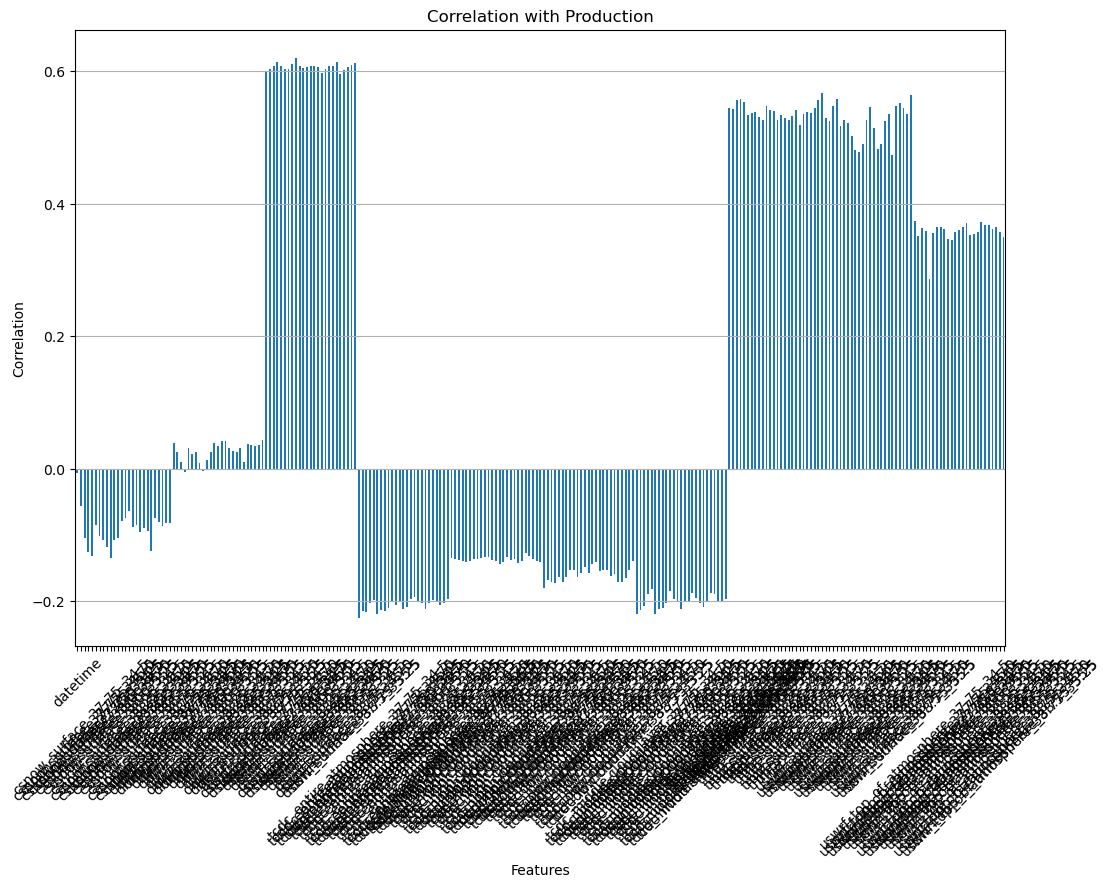

In [2]:
correlation_matrix = available_data.corr()

plt.figure(figsize=(12, 8))
correlation_matrix['production'].drop('production').plot(kind='bar')
plt.title("Correlation with Production")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


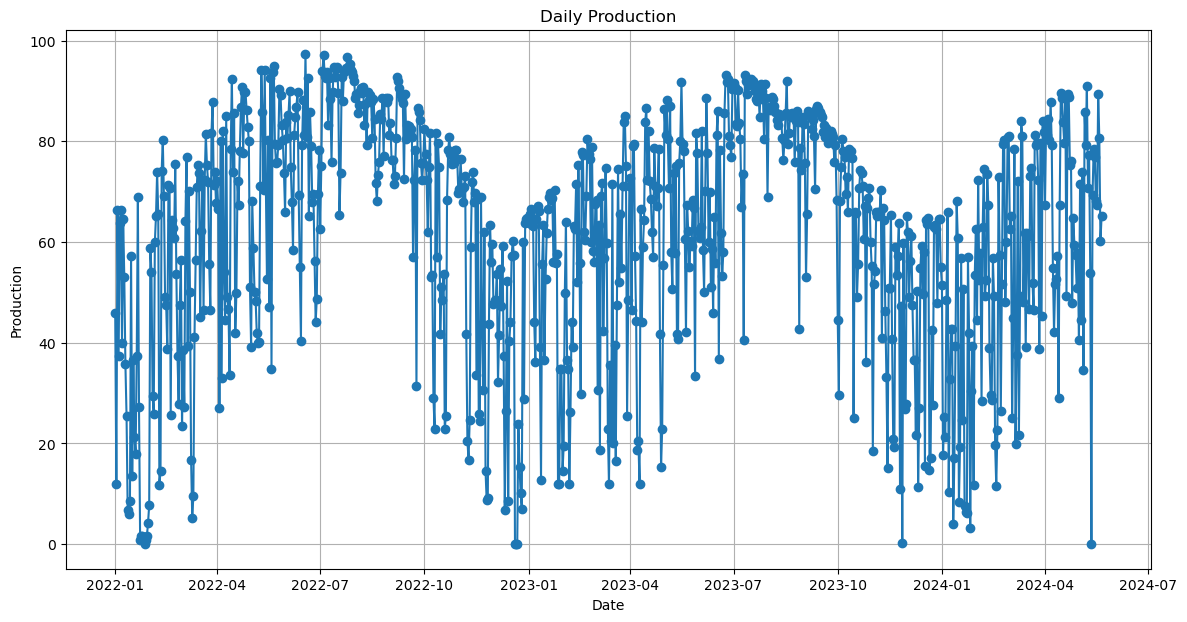

C:\Users\ardak\AppData\Local\Temp\ipykernel_10036\2097602639.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_production = available_data.resample('H', on='datetime').sum()


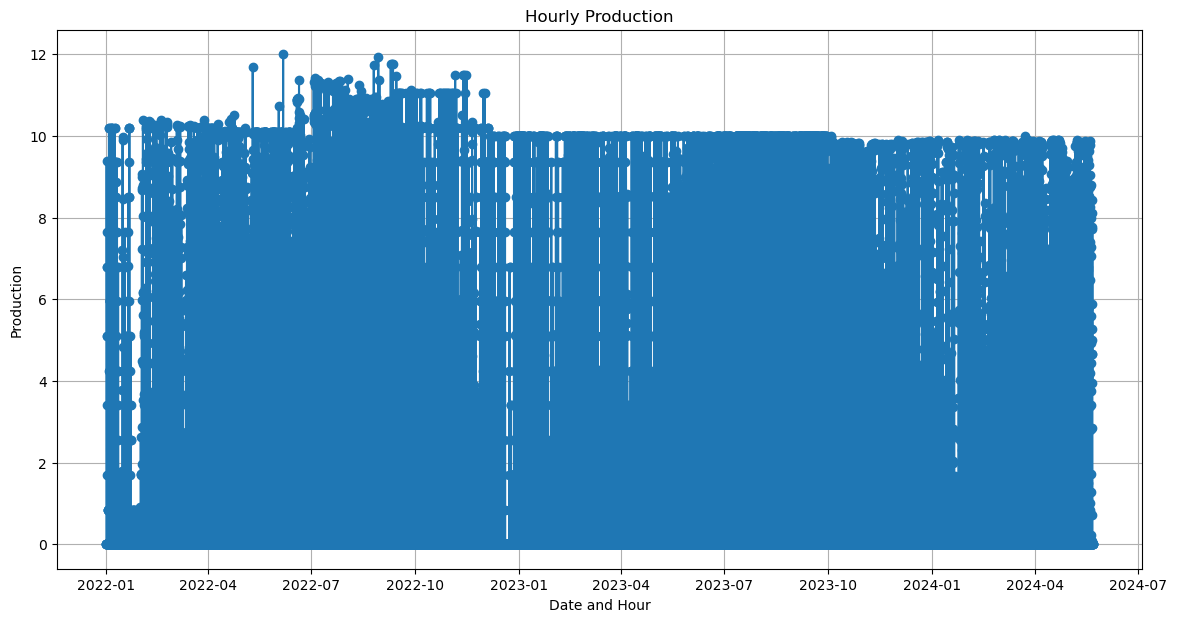

In [3]:
import matplotlib.pyplot as plt

# Aggregate production data by day
daily_production = available_data.resample('D', on='datetime').sum()

# Plot daily production
plt.figure(figsize=(14, 7))
plt.plot(daily_production.index, daily_production['production'], marker='o', linestyle='-')
plt.title('Daily Production')
plt.xlabel('Date')
plt.ylabel('Production')
plt.grid(True)
plt.show()

# Aggregate production data by hour
hourly_production = available_data.resample('H', on='datetime').sum()

# Plot hourly production
plt.figure(figsize=(14, 7))
plt.plot(hourly_production.index, hourly_production['production'], marker='o', linestyle='-')
plt.title('Hourly Production')
plt.xlabel('Date and Hour')
plt.ylabel('Production')
plt.grid(True)
plt.show()


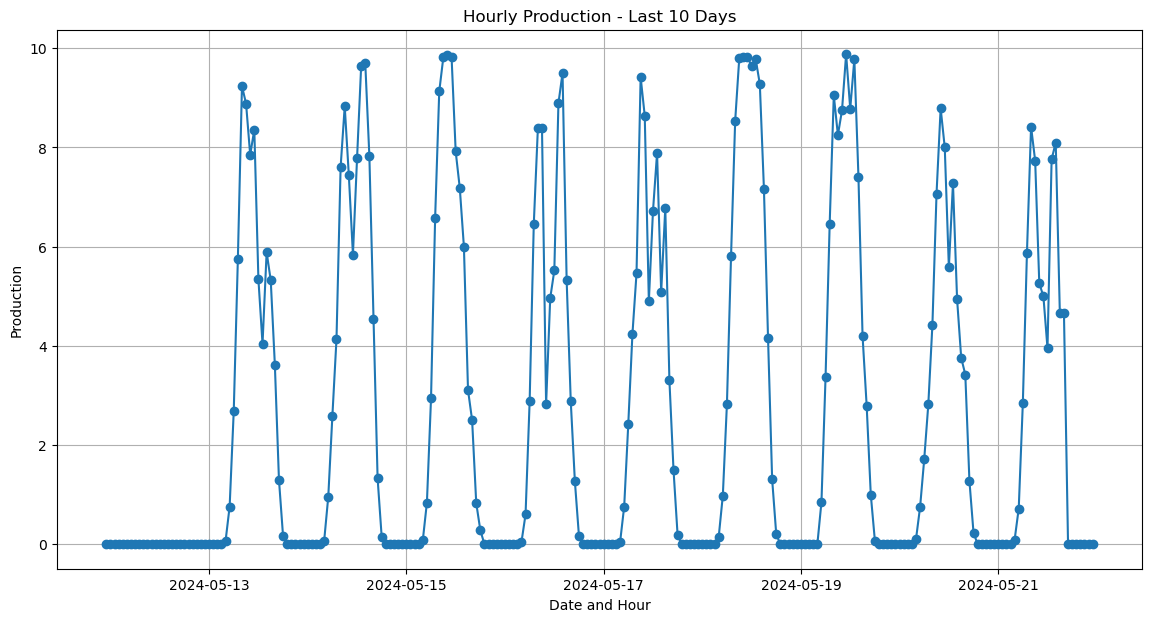

In [4]:
# Filter the last 10 days of data
last_10_days = hourly_production.loc[hourly_production.index >= hourly_production.index[-1] - pd.Timedelta(days=10)]

# Plot hourly production for the last 10 days
plt.figure(figsize=(14, 7))
plt.plot(last_10_days.index, last_10_days['production'], marker='o', linestyle='-')
plt.title('Hourly Production - Last 10 Days')
plt.xlabel('Date and Hour')
plt.ylabel('Production')
plt.grid(True)
plt.show()


C:\Users\ardak\AppData\Local\Temp\ipykernel_10036\2859016865.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_production = available_data.resample('H', on='datetime').sum()


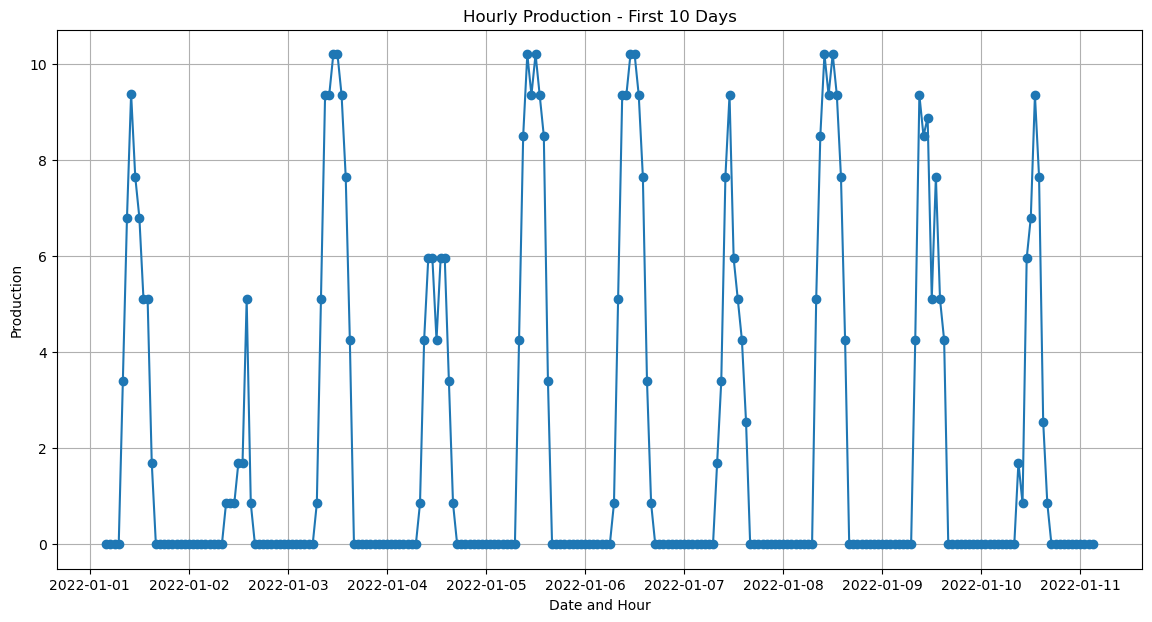

In [5]:
import matplotlib.pyplot as plt

# Assuming 'production' is the name of the production column
# Aggregate production data by hour
hourly_production = available_data.resample('H', on='datetime').sum()

# Filter the first 50 days of data
first_50_days = hourly_production.loc[hourly_production.index < hourly_production.index[0] + pd.Timedelta(days=10)]

# Plot hourly production for the first 50 days
plt.figure(figsize=(14, 7))
plt.plot(first_50_days.index, first_50_days['production'], marker='o', linestyle='-')
plt.title('Hourly Production - First 10 Days')
plt.xlabel('Date and Hour')
plt.ylabel('Production')
plt.grid(True)
plt.show()


C:\Users\ardak\AppData\Local\Temp\ipykernel_10036\2069712686.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_production = available_data.resample('H', on='datetime').sum()


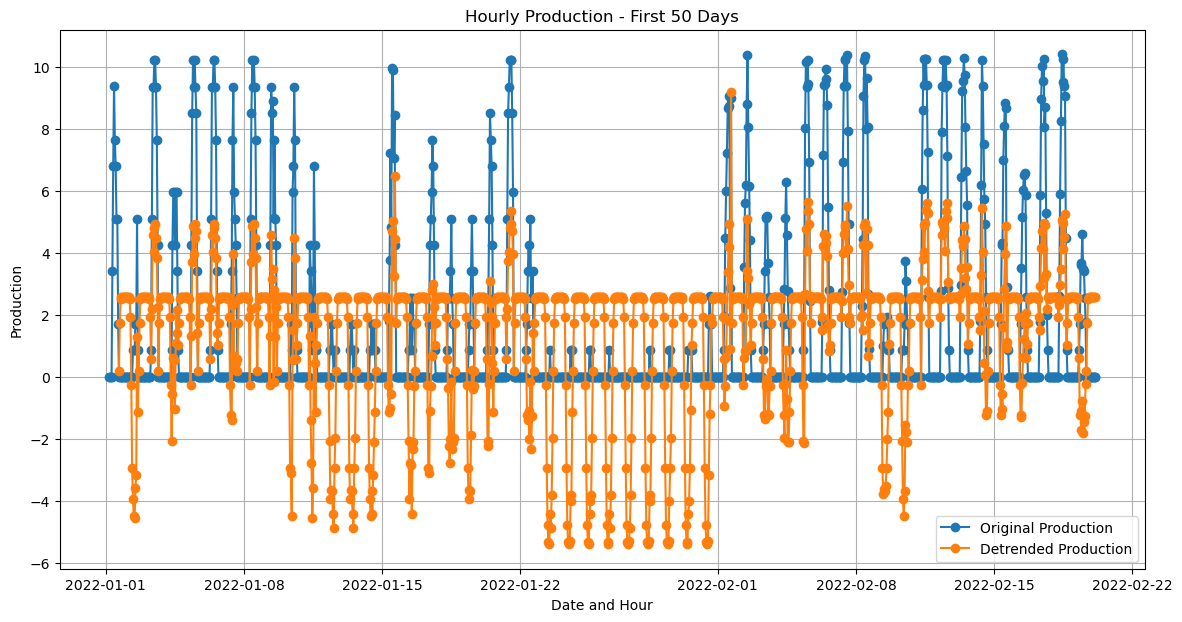

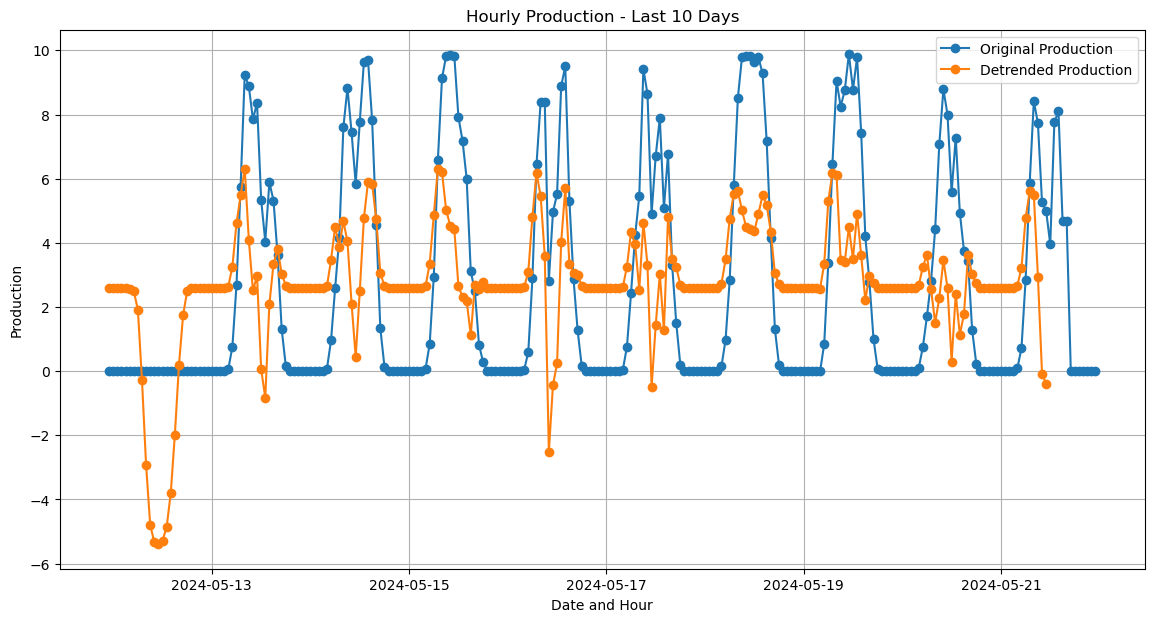

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'production' is the name of the production column
# Resample production data by hour
hourly_production = available_data.resample('H', on='datetime').sum()

# Decompose the time series to remove 24-hour seasonality
decomposition = seasonal_decompose(hourly_production['production'], model='additive', period=24)

# Extract the trend and residual components
detrended_production = decomposition.trend + decomposition.resid

# Plot the original and detrended data for the first 50 days
first_50_days = hourly_production.loc[hourly_production.index < hourly_production.index[0] + pd.Timedelta(days=50)]
detrended_first_50_days = detrended_production.loc[detrended_production.index < detrended_production.index[0] + pd.Timedelta(days=50)]

plt.figure(figsize=(14, 7))
plt.plot(first_50_days.index, first_50_days['production'], marker='o', linestyle='-', label='Original Production')
plt.plot(detrended_first_50_days.index, detrended_first_50_days, marker='o', linestyle='-', label='Detrended Production')
plt.title('Hourly Production - First 50 Days')
plt.xlabel('Date and Hour')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()

# Plot the original and detrended data for the last 10 days
last_10_days = hourly_production.loc[hourly_production.index >= hourly_production.index[-1] - pd.Timedelta(days=10)]
detrended_last_10_days = detrended_production.loc[detrended_production.index >= detrended_production.index[-1] - pd.Timedelta(days=10)]

plt.figure(figsize=(14, 7))
plt.plot(last_10_days.index, last_10_days['production'], marker='o', linestyle='-', label='Original Production')
plt.plot(detrended_last_10_days.index, detrended_last_10_days, marker='o', linestyle='-', label='Detrended Production')
plt.title('Hourly Production - Last 10 Days')
plt.xlabel('Date and Hour')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\ardak\AppData\Local\Temp\ipykernel_10036\2681738880.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_production = available_data.resample('H', on='datetime').sum()


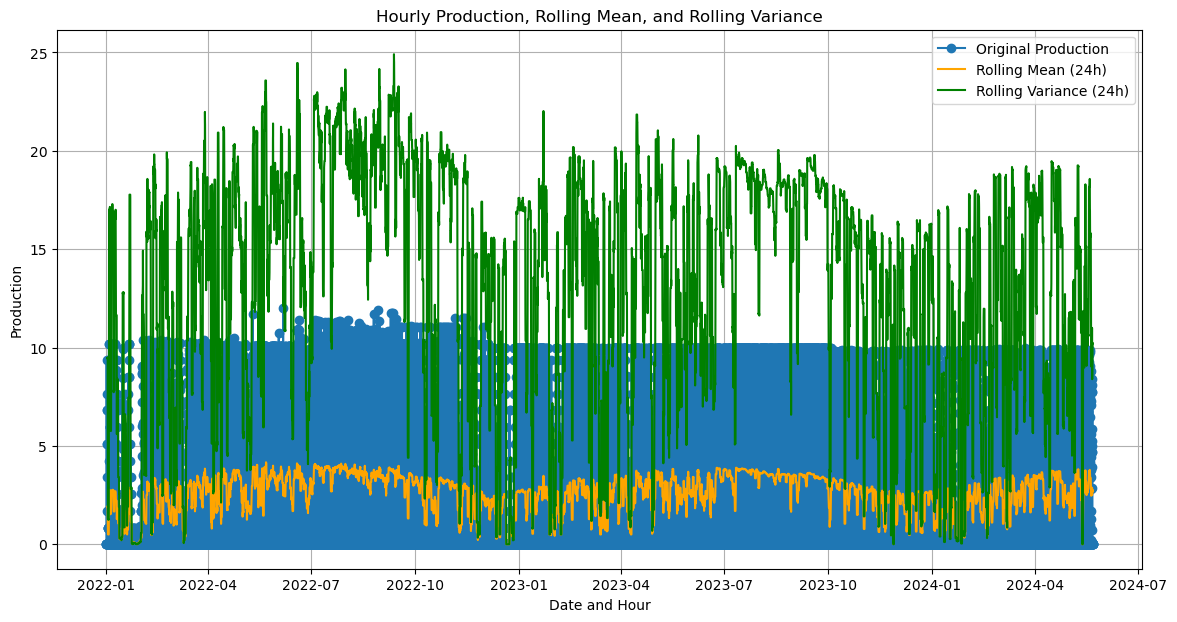

In [7]:
import matplotlib.pyplot as plt

# Assuming 'production' is the name of the production column
# Aggregate production data by hour
hourly_production = available_data.resample('H', on='datetime').sum()

# Calculate the rolling mean and rolling variance with a window of 24 hours (one day)
window_size = 24
rolling_mean = hourly_production['production'].rolling(window=window_size).mean()
rolling_variance = hourly_production['production'].rolling(window=window_size).var()

# Plot the original data, rolling mean, and rolling variance
plt.figure(figsize=(14, 7))

# Plot original data
plt.plot(hourly_production.index, hourly_production['production'], marker='o', linestyle='-', label='Original Production')

# Plot rolling mean
plt.plot(hourly_production.index, rolling_mean, linestyle='-', label='Rolling Mean (24h)', color='orange')

# Plot rolling variance (scaled for visualization)
plt.plot(hourly_production.index, rolling_variance, linestyle='-', label='Rolling Variance (24h)', color='green')

plt.title('Hourly Production, Rolling Mean, and Rolling Variance')
plt.xlabel('Date and Hour')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\ardak\AppData\Local\Temp\ipykernel_10036\1087130727.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_production = available_data.resample('H', on='datetime').sum()


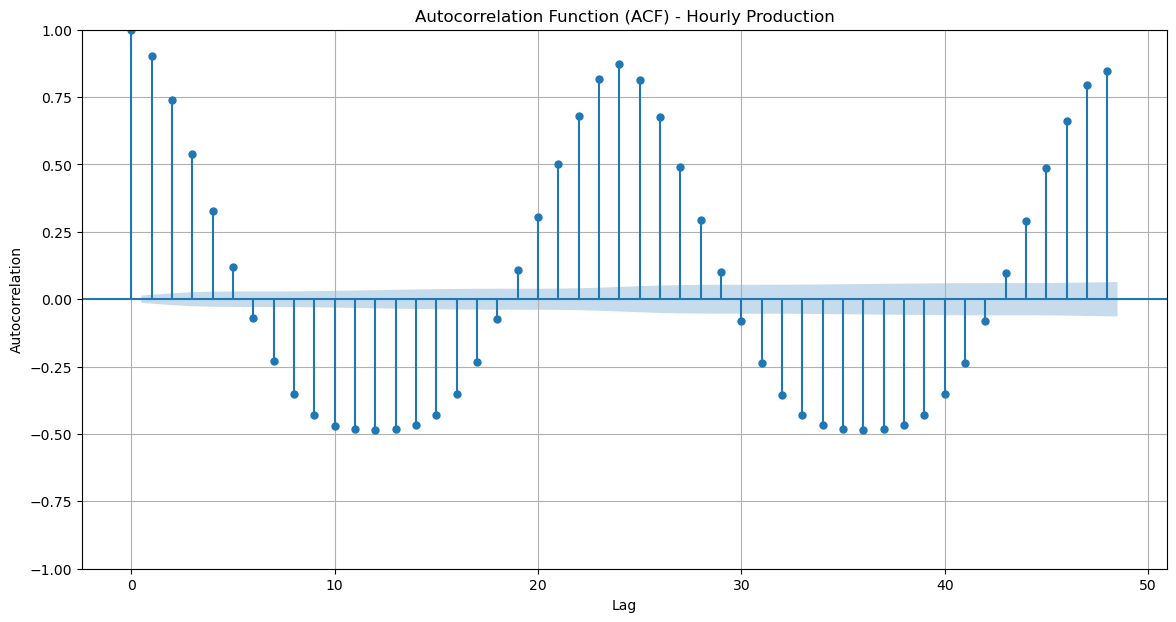

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Assuming 'production' is the name of the production column
# Aggregate production data by hour
hourly_production = available_data.resample('H', on='datetime').sum()

# Plot the ACF for the hourly production data
plt.figure(figsize=(14, 7))
plot_acf(hourly_production['production'], lags=48, ax=plt.gca())  # Lags set to 48 to cover up to 2 days
plt.title('Autocorrelation Function (ACF) - Hourly Production')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


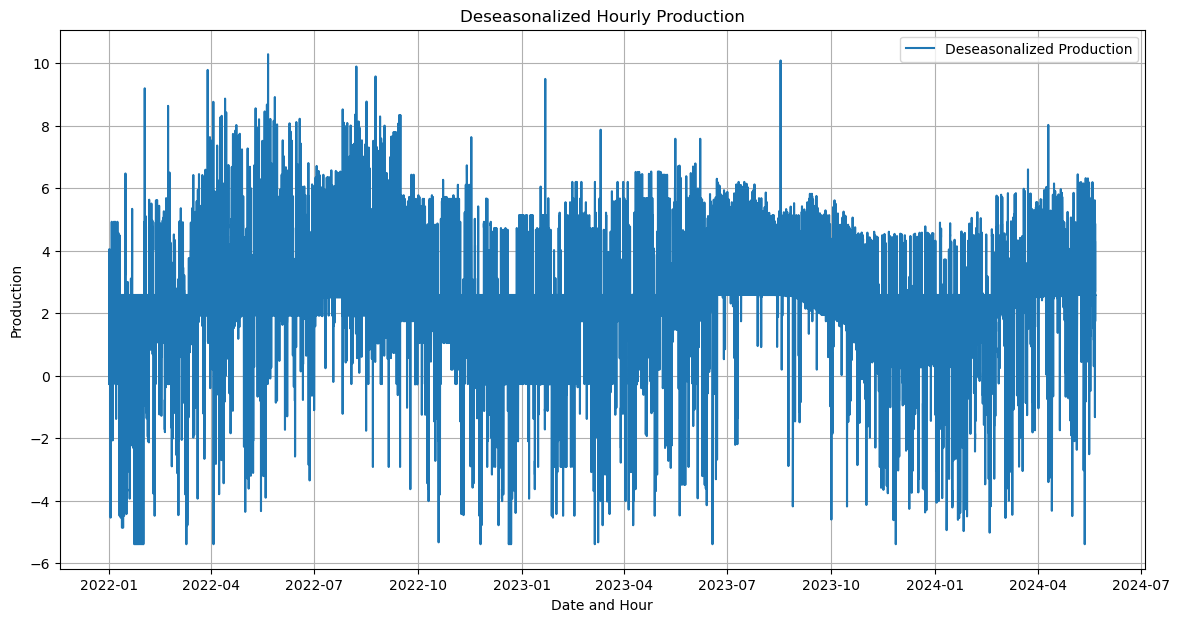

In [9]:
# Remove the seasonal component from the original data
deseasonalized = hourly_production['production'] - decomposition.seasonal

# Plot the deseasonalized data
plt.figure(figsize=(14, 7))
plt.plot(deseasonalized, label='Deseasonalized Production')
plt.title('Deseasonalized Hourly Production')
plt.xlabel('Date and Hour')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()

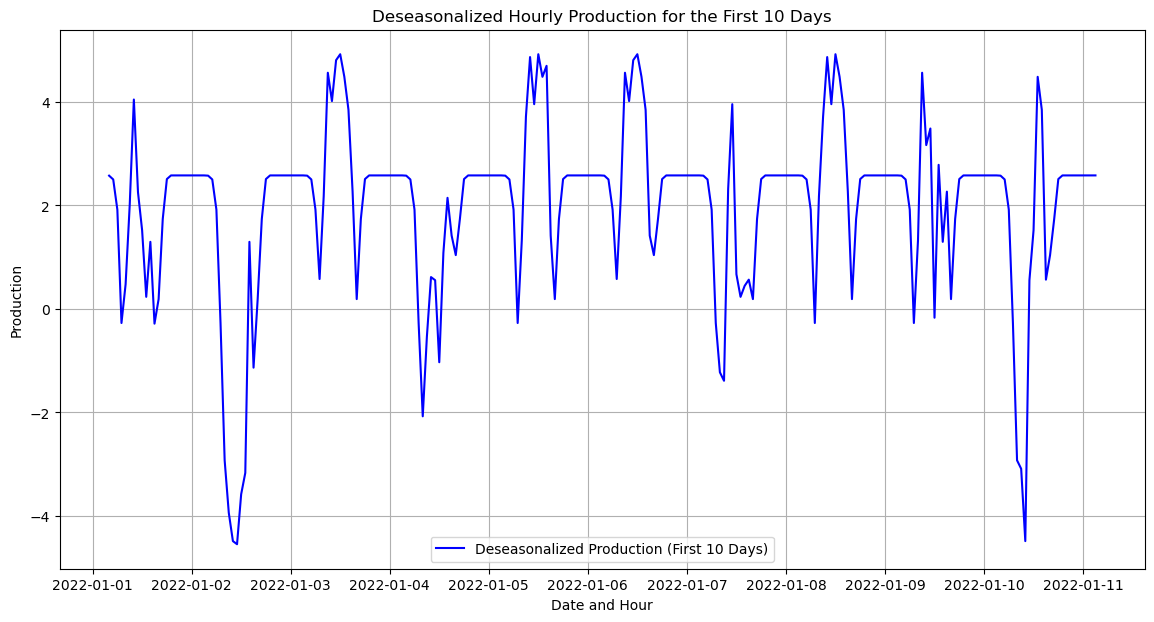

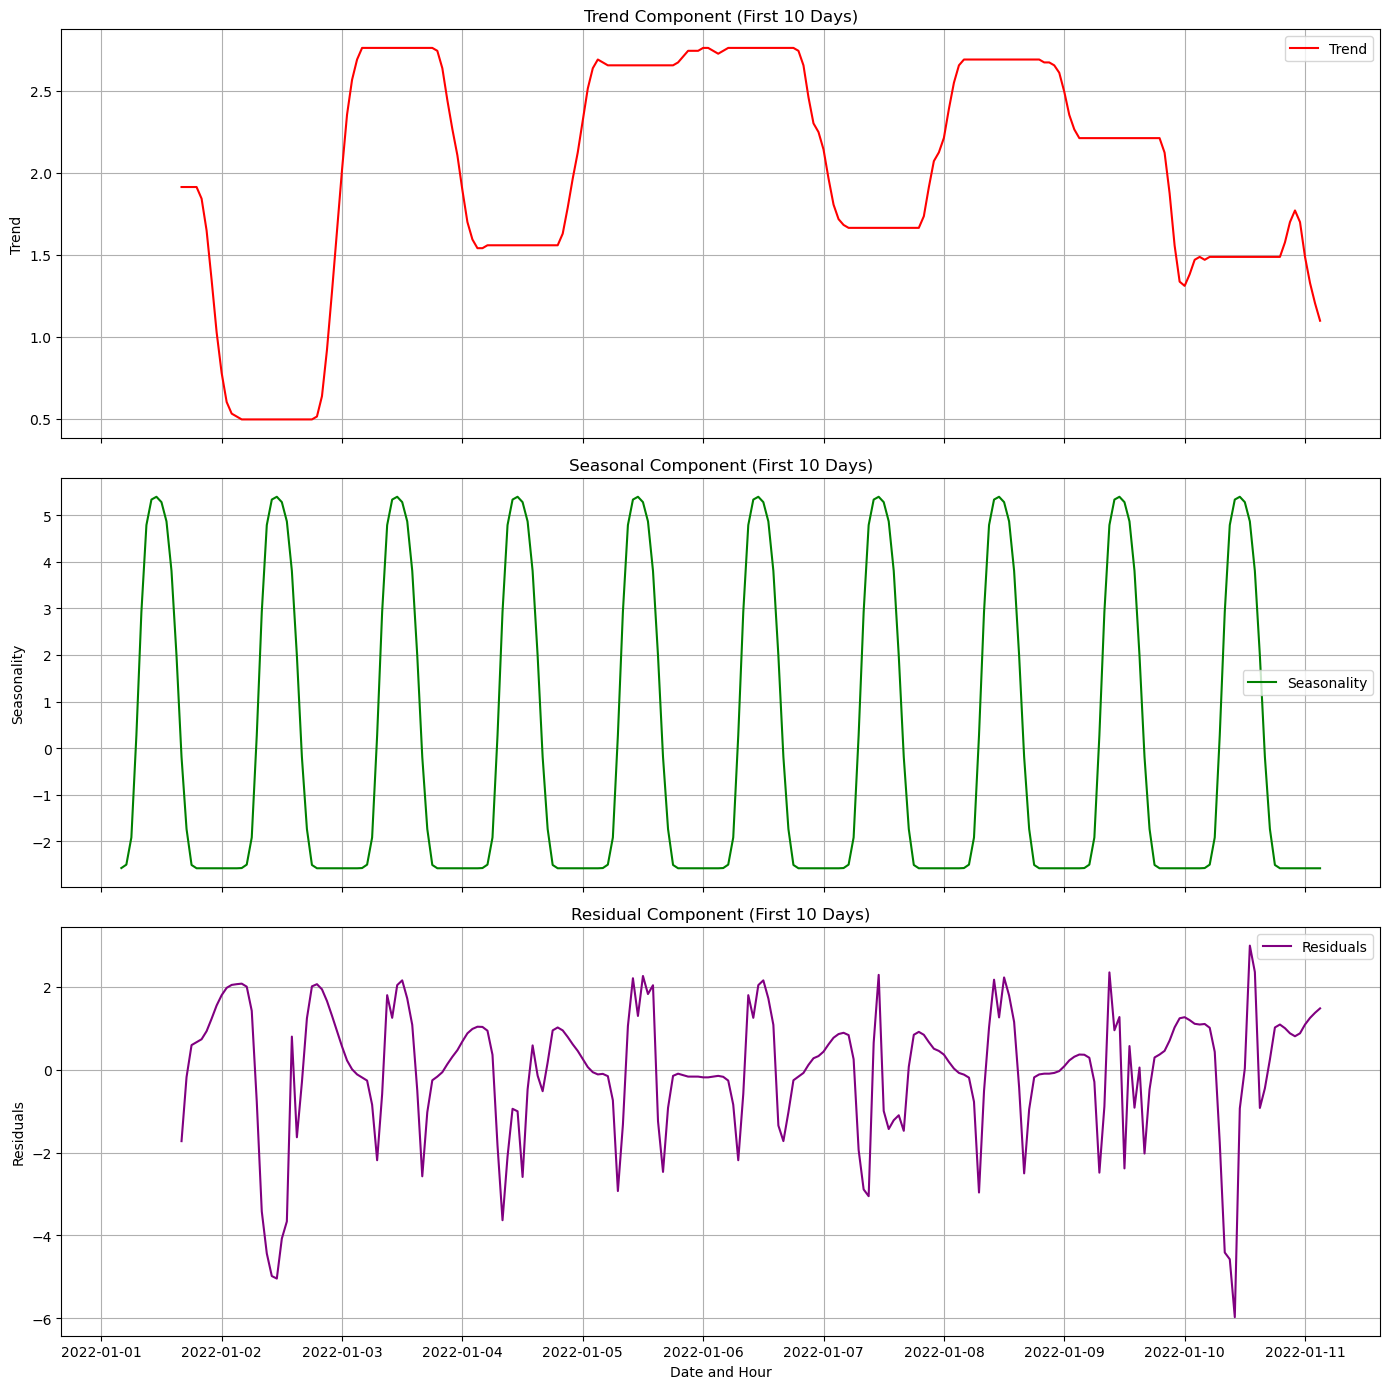

In [10]:
import matplotlib.pyplot as plt

# Assuming 'hourly_production' and 'decomposition' are already defined
# and that 'hourly_production' has a DateTime index

# Remove the seasonal component
deseasonalized = hourly_production['production'] - decomposition.seasonal

# Extract the first 10 days of data (240 hours)
first_10_days = deseasonalized.head(10 * 24)  # Assuming data is hourly

# Extract the first 10 days of trend, seasonal, and residual components
trend_first_10_days = decomposition.trend.head(10 * 24)
seasonal_first_10_days = decomposition.seasonal.head(10 * 24)
residuals_first_10_days = decomposition.resid.head(10 * 24)

# Plot the deseasonalized data for the first 10 days
plt.figure(figsize=(14, 7))
plt.plot(first_10_days, label='Deseasonalized Production (First 10 Days)', color='blue')
plt.title('Deseasonalized Hourly Production for the First 10 Days')
plt.xlabel('Date and Hour')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()

# Plot trend, seasonality, and residuals for the first 10 days
fig, axs = plt.subplots(3, 1, figsize=(14, 14), sharex=True)

axs[0].plot(trend_first_10_days, label='Trend', color='red')
axs[0].set_title('Trend Component (First 10 Days)')
axs[0].set_ylabel('Trend')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(seasonal_first_10_days, label='Seasonality', color='green')
axs[1].set_title('Seasonal Component (First 10 Days)')
axs[1].set_ylabel('Seasonality')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(residuals_first_10_days, label='Residuals', color='purple')
axs[2].set_title('Residual Component (First 10 Days)')
axs[2].set_xlabel('Date and Hour')
axs[2].set_ylabel('Residuals')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


C:\Users\ardak\AppData\Local\Temp\ipykernel_10036\1551586298.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_production = available_data.resample('H', on='datetime').sum()


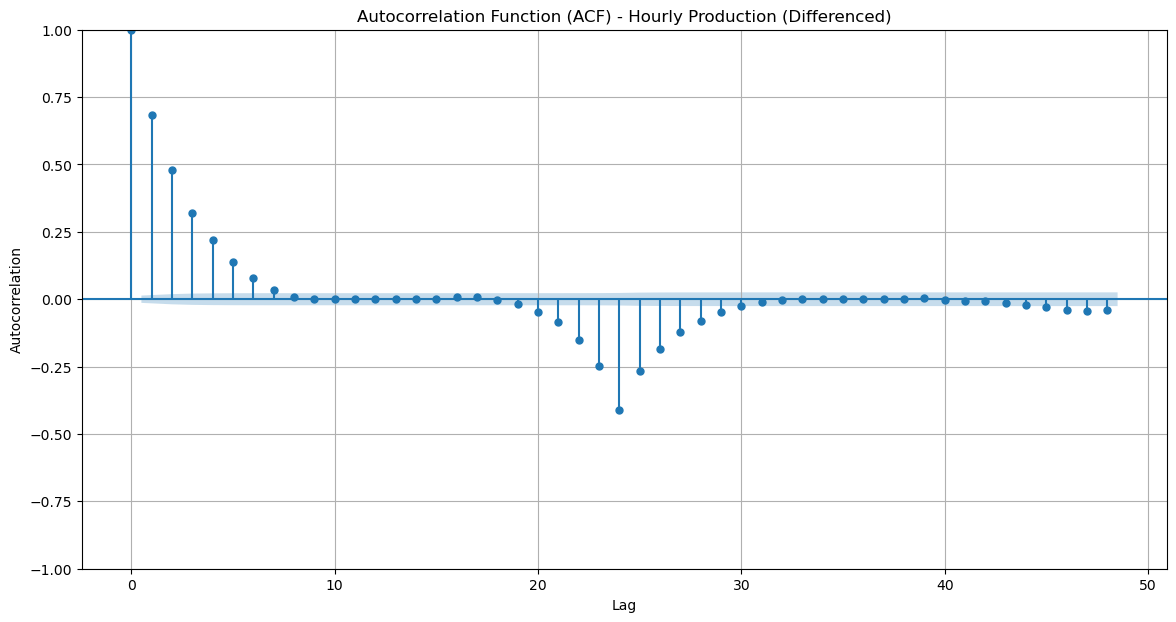

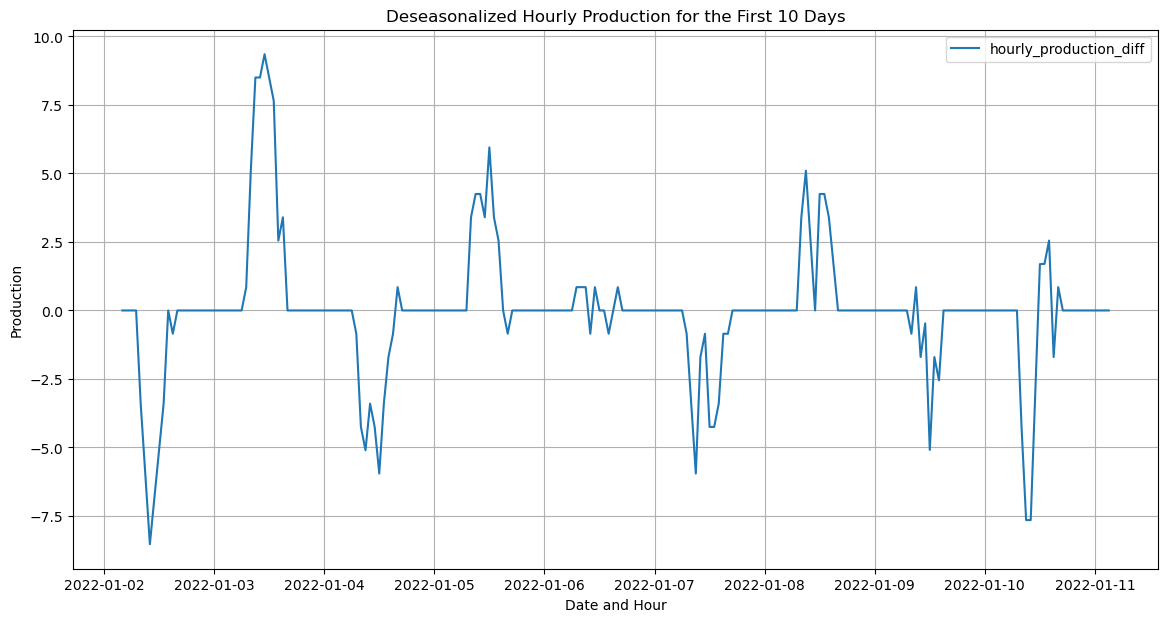

In [11]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Assuming 'production' is the name of the production column
# Aggregate production data by hour
hourly_production = available_data.resample('H', on='datetime').sum()

# Difference the data to remove daily seasonality
hourly_production_diff = hourly_production['production'].diff(24)
first_10_days = hourly_production_diff.head(10 * 24)

# Plot the ACF for the differenced hourly production data
plt.figure(figsize=(14, 7))
plot_acf(hourly_production_diff.dropna(), lags=48, ax=plt.gca())  # Lags set to 48 to cover up to 2 days
plt.title('Autocorrelation Function (ACF) - Hourly Production (Differenced)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


# Plot the deseasonalized data for the first 10 days
plt.figure(figsize=(14, 7))
plt.plot(first_10_days, label='hourly_production_diff')
plt.title('Deseasonalized Hourly Production for the First 10 Days')
plt.xlabel('Date and Hour')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()




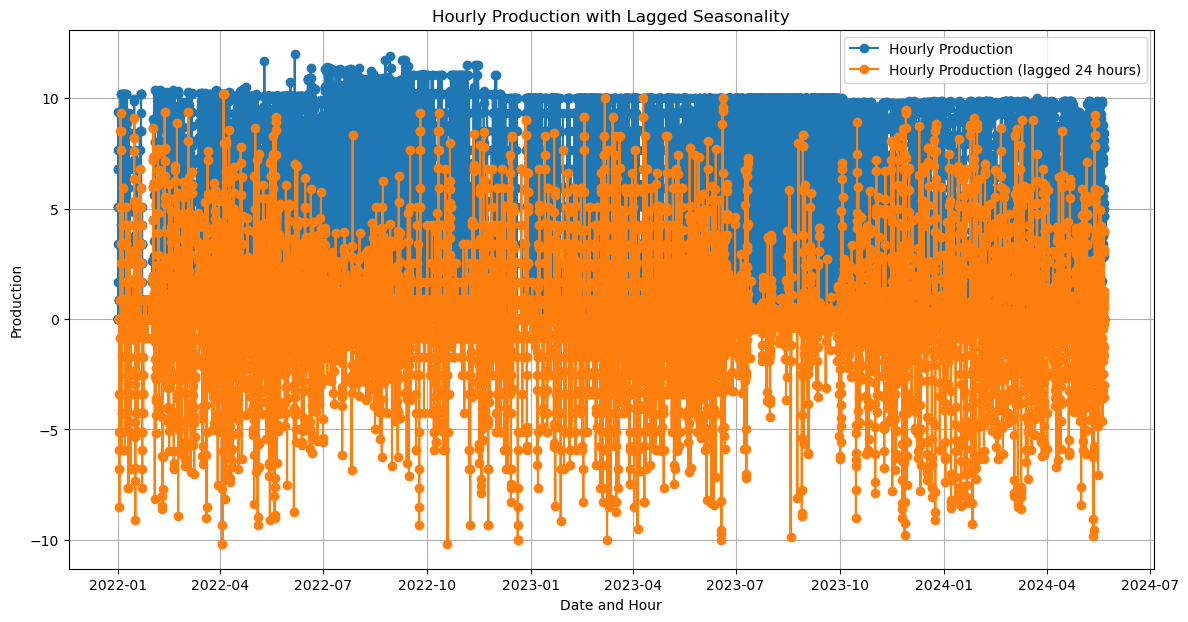

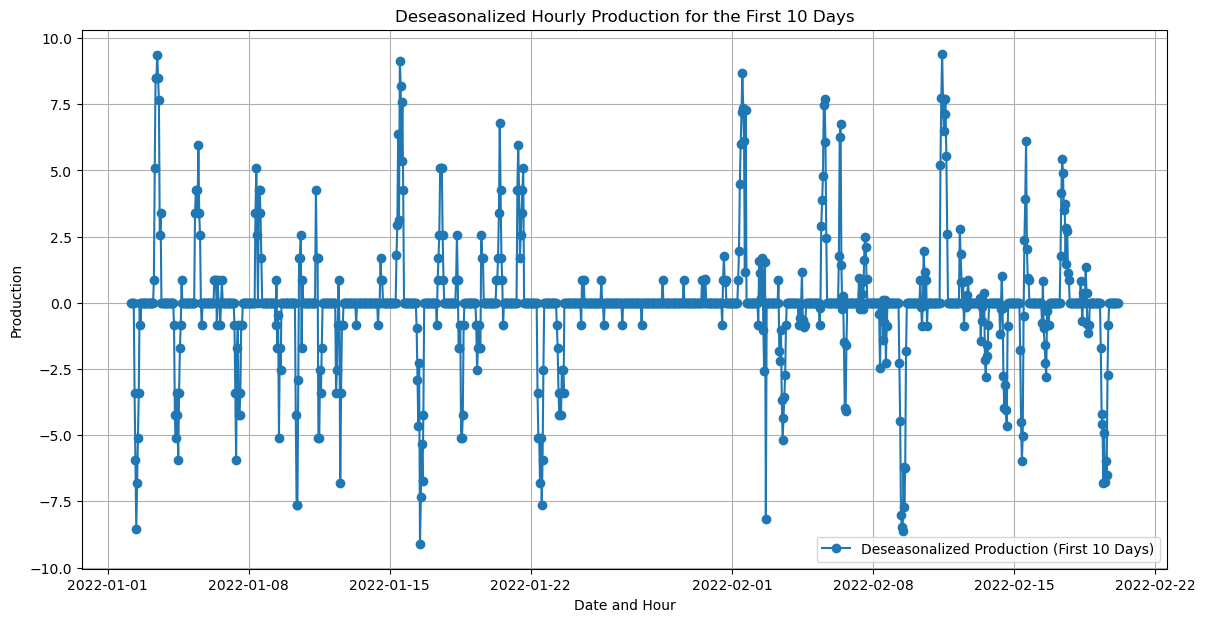

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have 'hourly_production' DataFrame and it has datetime index

# Apply a lag of 24 hours to the entire dataset
# 7 günlük gecikmeyi oluştur
hourly_production['lag_24_total'] = hourly_production['production'].shift(24)

# Fark sütununu oluştur
hourly_production['lag_24_diff'] = hourly_production['production'] - hourly_production['lag_24_total']

# Plot hourly production along with lagged production for all days
plt.figure(figsize=(14, 7))
plt.plot(hourly_production.index, hourly_production['production'], marker='o', linestyle='-', label='Hourly Production')
plt.plot(hourly_production.index, hourly_production['lag_24_diff'], marker='o', linestyle='-', label='Hourly Production (lagged 24 hours)')

plt.title('Hourly Production with Lagged Seasonality')
plt.xlabel('Date and Hour')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()

# Plot deseasonalized production for the first 10 days
first_10_days = hourly_production['lag_24_diff'].head(50 * 24)
plt.figure(figsize=(14, 7))
plt.plot(first_10_days, marker='o', linestyle='-', label='Deseasonalized Production (First 10 Days)')

plt.title('Deseasonalized Hourly Production for the First 10 Days')
plt.xlabel('Date and Hour')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


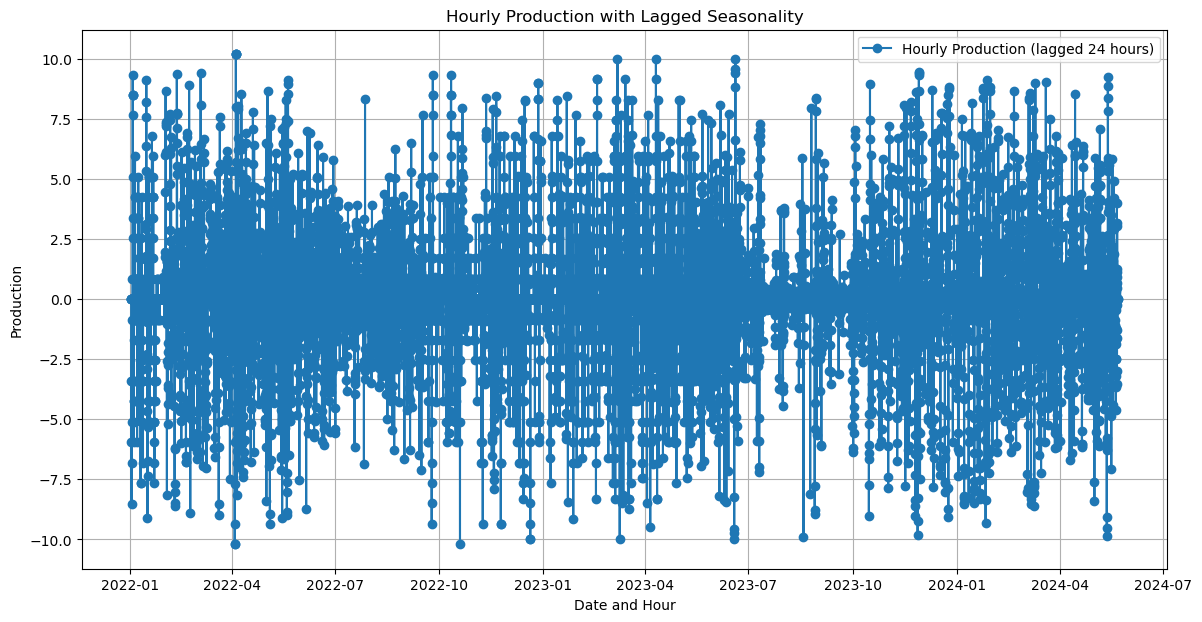

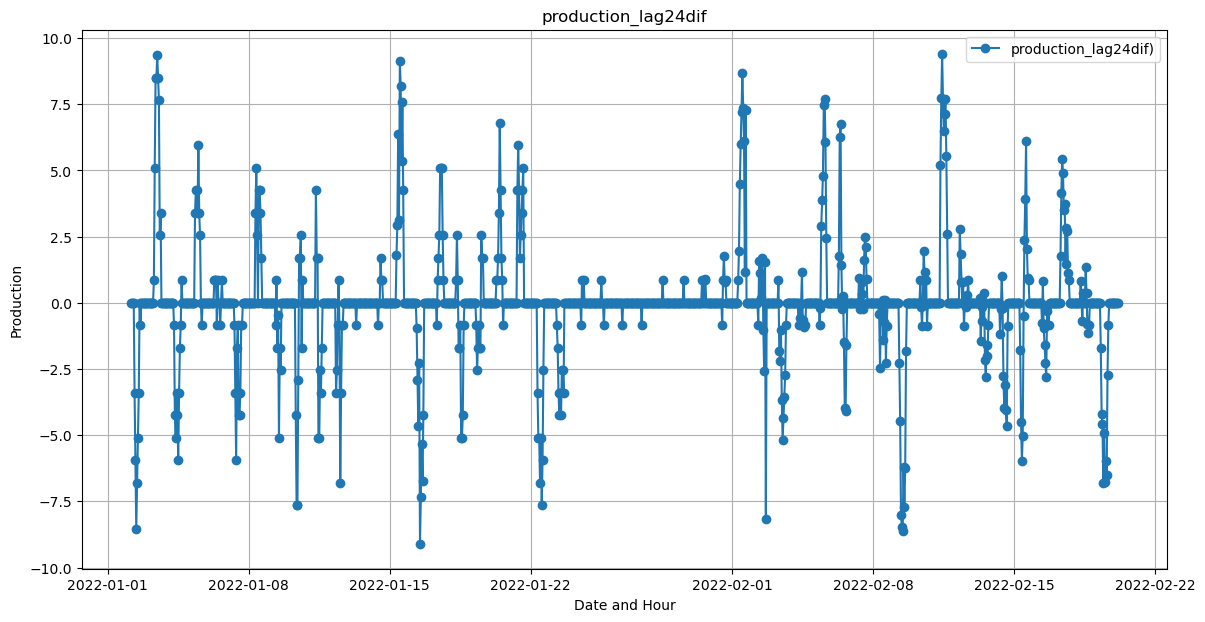

In [13]:
production_lag24dif =  hourly_production['production'].diff(periods=24)
hourly_production['production_lag24dif'] = production_lag24dif

# Plot hourly production along with lagged production for all days
plt.figure(figsize=(14, 7))
# plt.plot(hourly_production.index, hourly_production['production'], marker='o', linestyle='-', label='Hourly Production')
plt.plot(hourly_production.index, hourly_production['production_lag24dif'], marker='o', linestyle='-', label='Hourly Production (lagged 24 hours)')

plt.title('Hourly Production with Lagged Seasonality')
plt.xlabel('Date and Hour')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()
first_10_days = hourly_production['production_lag24dif'].head(50 * 24)
plt.figure(figsize=(14, 7))
plt.plot(first_10_days, marker='o', linestyle='-', label='production_lag24dif)')

plt.title('production_lag24dif')
plt.xlabel('Date and Hour')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1400x700 with 0 Axes>

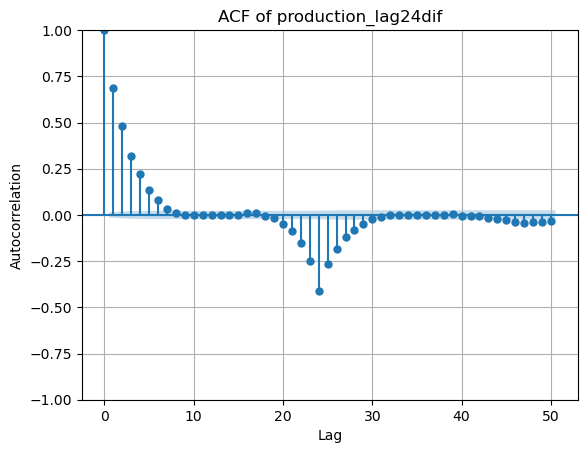

In [14]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF of production_lag24dif
plt.figure(figsize=(14, 7))
plot_acf(hourly_production['lag_24_diff'].dropna(), lags=50)
plt.title('ACF of production_lag24dif')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()


In [15]:
from statsmodels.tsa.stattools import kpss

# KPSS birim kök testi
kpss_test_result = kpss(hourly_production['production'].dropna())
print("KPSS Test Statistics:", kpss_test_result[0])
print("KPSS p-value:", kpss_test_result[1])
print("KPSS Test Critical Values:", kpss_test_result[3])


KPSS Test Statistics: 1.0107326638660215
KPSS p-value: 0.01
KPSS Test Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\ardak\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [16]:
from statsmodels.tsa.stattools import kpss

# KPSS birim kök testi
kpss_test_result = kpss(hourly_production['lag_24_diff'].dropna())
print("KPSS Test Statistics:", kpss_test_result[0])
print("KPSS p-value:", kpss_test_result[1])
print("KPSS Test Critical Values:", kpss_test_result[3])


KPSS Test Statistics: 0.0028949455294030252
KPSS p-value: 0.1
KPSS Test Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\ardak\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


C:\Users\ardak\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ardak\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ardak\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                16732
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -45573.103
Date:                Wed, 05 Jun 2024   AIC                          91152.206
Time:                        22:02:52   BIC                          91175.381
Sample:                             0   HQIC                         91159.854
                              - 16732                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0030      0.008     -0.385      0.700      -0.018       0.012
ma.L1         -0.9999      0.000  -2382.686      0.000      -1.001      -0.999
sigma2        13.5899      0.192     70.678      0.0

C:\Users\ardak\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


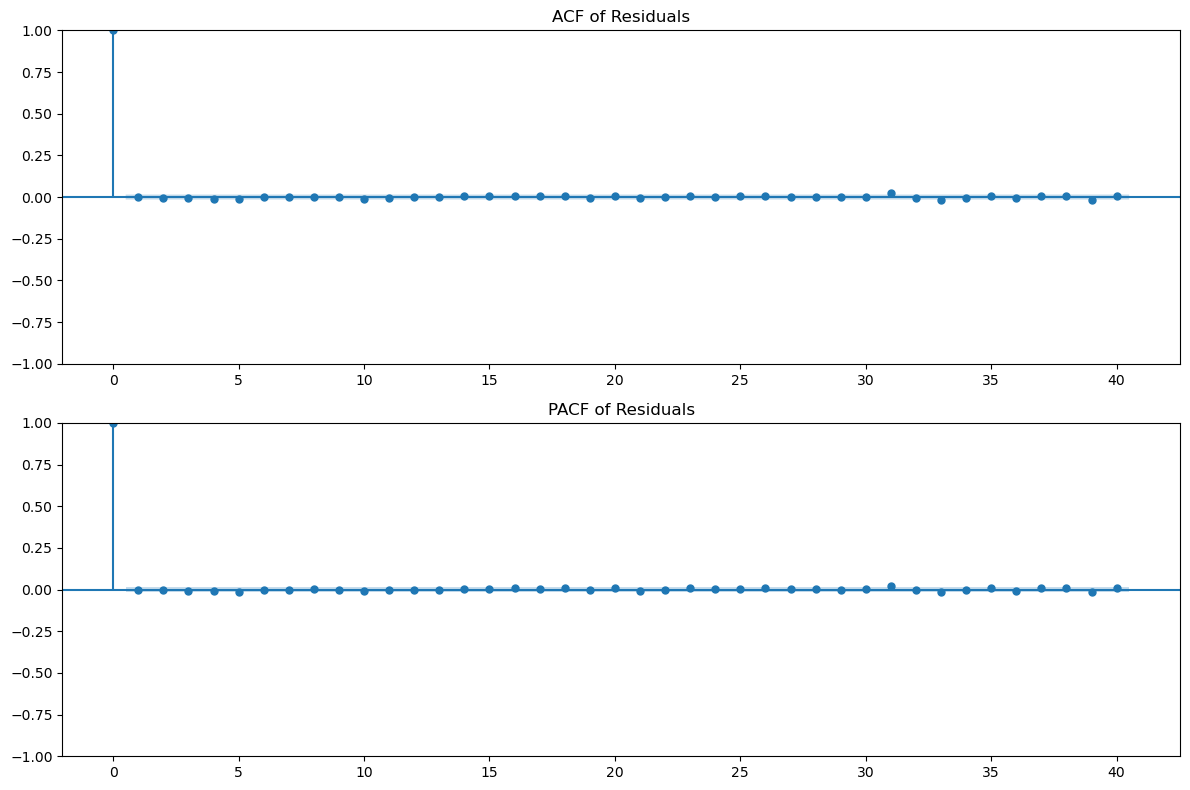

In [17]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA



# Drop missing values
available_data.dropna(inplace=True)

# Define independent and dependent variables
X = available_data.drop(columns=['datetime', 'production'])
y = available_data['production']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the ARIMA model
arima_model = ARIMA(y_train, order=(1,1,1)).fit()

# Display the model summary
print(arima_model.summary())

# Residuals (error terms)
residuals = arima_model.resid

# ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(residuals, lags=40, ax=ax[0])
ax[0].set_title('ACF of Residuals')

# PACF plot
plot_pacf(residuals, lags=40, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()


C:\Users\ardak\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ardak\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           production   No. Observations:                16732
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 24)   Log Likelihood              -45587.461
Date:                              Wed, 05 Jun 2024   AIC                          91186.921
Time:                                      22:07:43   BIC                          91233.263
Sample:                                           0   HQIC                         91202.216
                                            - 16732                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9871      7.186     -0.137      0.891     -15.071      13.097
ar.L2         -0.00

C:\Users\ardak\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


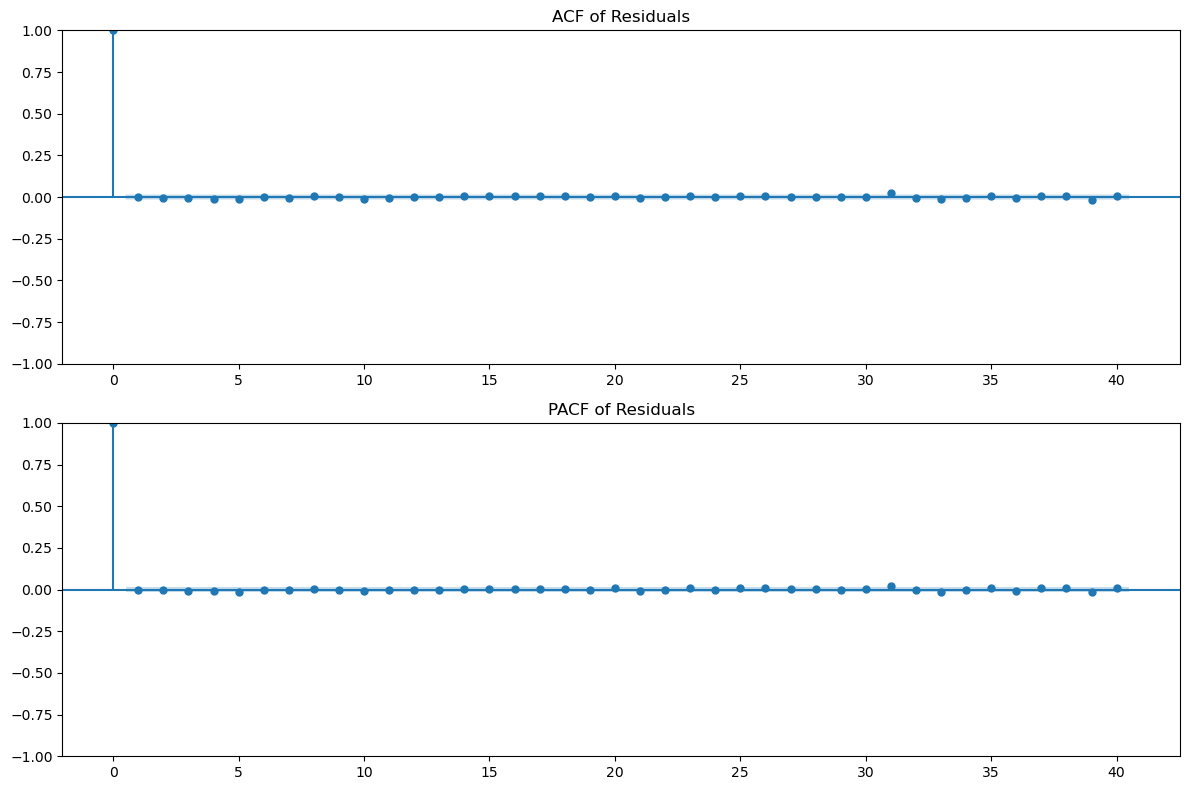

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example fitting SARIMA model
sarima_model = SARIMAX(y_train, order=(2, 1, 2), seasonal_order=(0,1,1,24)).fit()

# Model summary
print(sarima_model.summary())
# Residuallar (hata terimleri)
residuals = sarima_model.resid

# ACF ve PACF grafikleri
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF grafiği
plot_acf(residuals, lags=40, ax=ax[0])
ax[0].set_title('ACF of Residuals')

# PACF grafiği
plot_pacf(residuals, lags=40, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()

In [19]:
import statsmodels.api as sm
available_data = available_data.dropna()
X = available_data.drop(columns=['datetime',"production"])
y = available_data['production']

lm_model1 = sm.OLS(y, sm.add_constant(X)).fit()

print(lm_model1.summary())

                            OLS Regression Results                            
Dep. Variable:             production   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     258.0
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        22:09:03   Log-Likelihood:                -42192.
No. Observations:               20915   AIC:                         8.489e+04
Df Residuals:                   20664   BIC:                         8.688e+04
Df Model:                         250                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

                            OLS Regression Results                            
Dep. Variable:             production   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     425.6
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        22:09:10   Log-Likelihood:                -38006.
No. Observations:               20914   AIC:                         7.651e+04
Df Residuals:                   20663   BIC:                         7.851e+04
Df Model:                         250                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

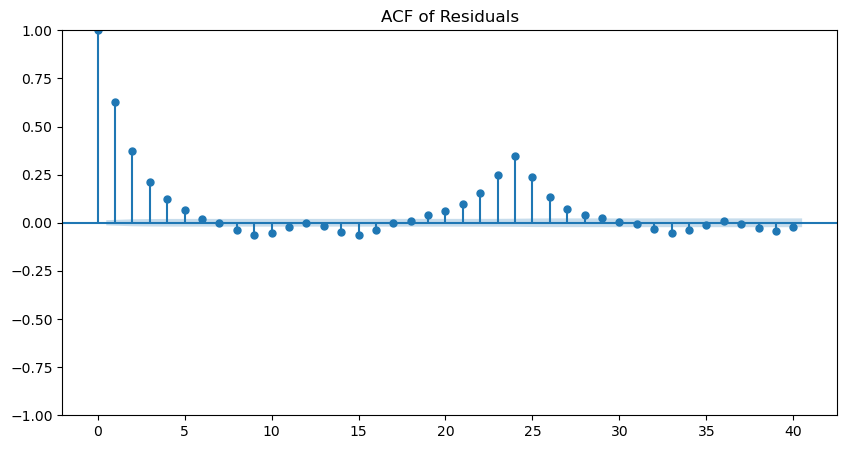

In [20]:
available_data['production'] = available_data['production'].shift(1)

available_data.dropna(inplace=True)

X = available_data.drop(columns=["datetime", "production"])
y = available_data['production']

lm_model2 = sm.OLS(y, sm.add_constant(X)).fit()

print(lm_model2.summary())
residuals = lm_model2.resid

fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(residuals, lags=40, ax=ax)
plt.title('ACF of Residuals')
plt.show()


                            OLS Regression Results                            
Dep. Variable:             production   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     315.1
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        22:09:13   Log-Likelihood:                -40518.
No. Observations:               20890   AIC:                         8.154e+04
Df Residuals:                   20639   BIC:                         8.353e+04
Df Model:                         250                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

C:\Users\ardak\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


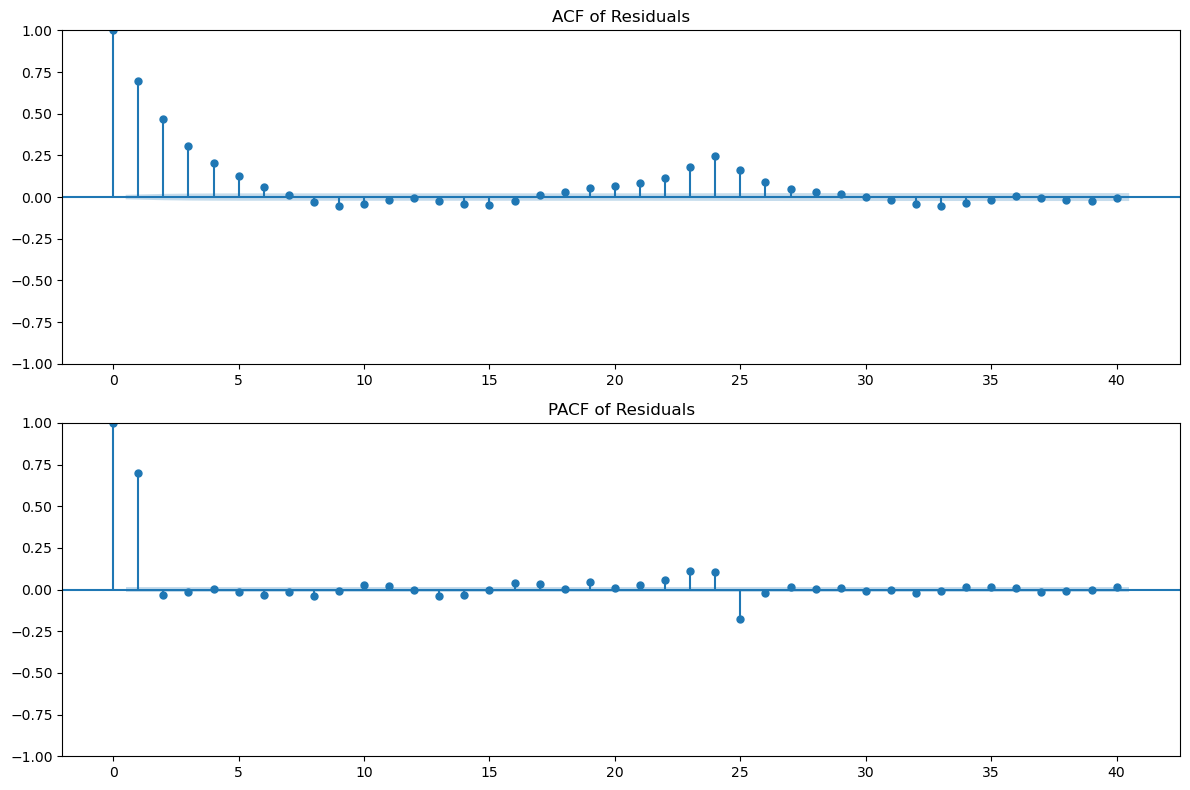

In [21]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

available_data['production'] = available_data['production'].shift(24)

available_data.dropna(inplace=True)

X = available_data.drop(columns=["datetime", "production"])
y = available_data['production']

lm_model3 = sm.OLS(y, sm.add_constant(X)).fit()

print(lm_model3.summary())

residuals = lm_model3.resid

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(residuals, lags=40, ax=ax[0])
ax[0].set_title('ACF of Residuals')

plot_pacf(residuals, lags=40, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA



# Drop missing values
available_data.dropna(inplace=True)

# Define independent and dependent variables
X = available_data.drop(columns=['datetime', 'production'])
y = available_data['production']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the ARIMA model
arima_model = ARIMA(y_train, order=(1,1,1)).fit()

# Display the model summary
print(arima_model.summary())

# Residuals (error terms)
residuals = arima_model.resid

# ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(residuals, lags=40, ax=ax[0])
ax[0].set_title('ACF of Residuals')

# PACF plot
plot_pacf(residuals, lags=40, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()


In [ ]:
from pmdarima import auto_arima

auto_arima_model = auto_arima(y_train, seasonal=True,m=24, stepwise=True, trace=True)

print(auto_arima_model.summary())

residuals = auto_arima_model.resid()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(residuals, lags=40, ax=ax[0])
ax[0].set_title('ACF of Residuals')

plot_pacf(residuals, lags=40, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(y_train, order=(2, 1, 0), seasonal_order=(0,1,1,24)).fit()

# Model summary
print(sarima_model.summary())
residuals = sarima_model.resid

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(residuals, lags=40, ax=ax[0])
ax[0].set_title('ACF of Residuals')

plot_pacf(residuals, lags=40, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# OLS modelinin tahminlerini alın
ols_predictions = lm_model1.predict(sm.add_constant(X_test))

# ARIMA modelinin tahminlerini alın
arima_predictions = arima_model.forecast(steps=len(X_test))

# SARIMA modelinin tahminlerini alın
sarima_predictions = sarima_model.forecast(steps=len(X_test))

# WMAPE, MAD ve MSE hesaplamaları
wmape_ols = np.mean(np.abs((y_test - ols_predictions) / y_test)) * 100
wmape_arima = np.mean(np.abs((y_test - arima_predictions) / y_test)) * 100
wmape_sarima = np.mean(np.abs((y_test - sarima_predictions) / y_test)) * 100

mad_ols = mean_absolute_error(y_test, ols_predictions)
mad_arima = mean_absolute_error(y_test, arima_predictions)
mad_sarima = mean_absolute_error(y_test, sarima_predictions)

mse_ols = mean_squared_error(y_test, ols_predictions)
mse_arima = mean_squared_error(y_test, arima_predictions)
mse_sarima = mean_squared_error(y_test, sarima_predictions)

# AIC ve BIC değerlerini alın
aic_ols = lm_model1.aic
aic_arima = arima_model.aic
aic_sarima = sarima_model.aic

bic_ols = lm_model1.bic
bic_arima = arima_model.bic
bic_sarima = sarima_model.bic

# Metriklerin değerlerini görüntüleme
print("OLS Model Metrics:")
print("WMAPE:", wmape_ols)
print("MAD:", mad_ols)
print("MSE:", mse_ols)
print("AIC:", aic_ols)
print("BIC:", bic_ols)
print("\n")

print("ARIMA Model Metrics:")
print("WMAPE:", wmape_arima)
print("MAD:", mad_arima)
print("MSE:", mse_arima)
print("AIC:", aic_arima)
print("BIC:", bic_arima)
print("\n")

print("SARIMA Model Metrics:")
print("WMAPE:", wmape_sarima)
print("MAD:", mad_sarima)
print("MSE:", mse_sarima)
print("AIC:", aic_sarima)
print("BIC:", bic_sarima)


C:\Users\ardak\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ardak\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


OLS Model Metrics:
WMAPE: inf
MAD: 1.337007515831581
MSE: 3.2833649003980296
AIC: 84886.21193687376
BIC: 86881.2156297267


ARIMA Model Metrics:
WMAPE: inf
MAD: 3.216482704736275
MSE: 13.843958551407557
AIC: 91152.20552184162
BIC: 91175.3805775368


SARIMA Model Metrics:
WMAPE: inf
MAD: 3.2237961315392547
MSE: 13.870484850606617
AIC: 91186.92106939963
BIC: 91233.26256783317
